In [17]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [18]:
# CONSTANTS
img_height = 128
img_width = 128
image_channels = 3
annotation_channels = 1
factor_size = 8


In [19]:
def split_data(images, annotations, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images[indices[:train_samples]], annotations[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], annotations[indices[train_samples:]]
    return x_train, y_train, x_valid, y_valid


def get_single_frame(img_path, annotation_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=image_channels)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])

    label_img = tf.io.read_file(annotation_path)
    label_img = tf.image.decode_jpeg(label_img, channels=annotation_channels)
    label_img = tf.image.convert_image_dtype(label_img, tf.float32)
    label_img = tf.image.resize(label_img, [img_height, img_width])

    return {"image": img, "label": label_img} # it won't work if it's tuple


In [20]:
"""
# Create Datasets
DATA_DIR = "./data"
images_dir = Path(os.path.join(DATA_DIR, "images"))
annotation_dir = Path(os.path.join(DATA_DIR, "annotations"))

images = sorted(list(map(str, list(images_dir.glob("*")))))
annotations = sorted(list(map(str, list(annotation_dir.glob("*")))))

batch_size = 32
x_train, y_train, x_test, y_test = split_data(np.array(images), np.array(annotations), train_size=0.85)
x_train, y_train, x_valid, y_valid = split_data(x_train, y_train, train_size=0.85)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
val_ds = (
    val_ds.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(
        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)
"""

'\n# Create Datasets\nDATA_DIR = "./data"\nimages_dir = Path(os.path.join(DATA_DIR, "images"))\nannotation_dir = Path(os.path.join(DATA_DIR, "annotations"))\n\nimages = sorted(list(map(str, list(images_dir.glob("*")))))\nannotations = sorted(list(map(str, list(annotation_dir.glob("*")))))\n\nbatch_size = 32\nx_train, y_train, x_test, y_test = split_data(np.array(images), np.array(annotations), train_size=0.85)\nx_train, y_train, x_valid, y_valid = split_data(x_train, y_train, train_size=0.85)\n\ntrain_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))\ntrain_ds = (\n    train_ds.map(\n        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE\n    )\n    .batch(batch_size)\n    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)\n)\n\nval_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))\nval_ds = (\n    val_ds.map(\n        get_single_frame, num_parallel_calls=tf.data.experimental.AUTOTUNE\n    )\n    .batch(batch_size)\n    .prefetch(buffer_size=tf

In [21]:
"""
# Save Datasets
DATASET_DIR = 'data/datasets'
ds_path = os.path.join(DATASET_DIR, 'train_ds')
tf.data.experimental.save(train_ds, ds_path)
ds_path = os.path.join(DATASET_DIR, 'val_ds')
tf.data.experimental.save(val_ds, ds_path)
ds_path = os.path.join(DATASET_DIR, 'test_ds')
tf.data.experimental.save(test_ds, ds_path)
"""

"\n# Save Datasets\nDATASET_DIR = 'data/datasets'\nds_path = os.path.join(DATASET_DIR, 'train_ds')\ntf.data.experimental.save(train_ds, ds_path)\nds_path = os.path.join(DATASET_DIR, 'val_ds')\ntf.data.experimental.save(val_ds, ds_path)\nds_path = os.path.join(DATASET_DIR, 'test_ds')\ntf.data.experimental.save(test_ds, ds_path)\n"

In [22]:
DATASET_DIR = 'data/datasets'
element_spec = {
    "image": tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
    "label": tf.TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
    }
train_ds = tf.data.experimental.load(os.path.join(DATASET_DIR, 'train_ds'), element_spec)
val_ds = tf.data.experimental.load(os.path.join(DATASET_DIR, 'val_ds'), element_spec)
test_ds = tf.data.experimental.load(os.path.join(DATASET_DIR, 'test_ds'), element_spec)

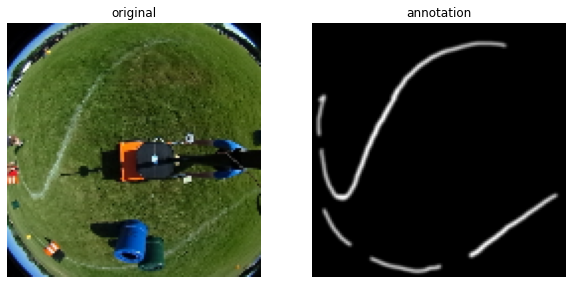

In [23]:
# check some data
def see_train_data(idx=0):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))
    for batch in train_ds.take(idx):
        image = batch["image"][0]
        ax[0].imshow((image * 255).numpy().astype("uint8"))
        ax[0].set_title("original")
        ax[0].axis("off")

        annotated_img = batch["label"][0]
        ax[1].imshow((annotated_img * 255).numpy().astype("uint8"), cmap='gray')
        ax[1].set_title("annotation")
        ax[1].axis("off")

see_train_data(1)


In [27]:
class AugmentLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name)
        self.augmentation_for_both = keras.models.Sequential([
            layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
            # layers.experimental.preprocessing.RandomRotation(0.05, fill_mode='constant'),
        ])
        self.augmentation_for_input = keras.models.Sequential([
          layers.experimental.preprocessing.RandomContrast(0.15)
        ]) 
        
    @staticmethod
    def merge_img(img1, img2):
        return tf.concat((img1, img2), axis=-1)

    @staticmethod
    def separate_img(img, divideIdx=-1):
        return img[:, :, :, :divideIdx], img[:, :, :, divideIdx:]
 
    def call(self, input_img, label_img):
        img = self.merge_img(input_img, label_img)
        img = self.augmentation_for_both(img)
        input_img, label_img = self.separate_img(img)
        input_img = self.augmentation_for_input(input_img)
        return input_img, label_img


class MSELayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name)
        self.loss_fn = keras.losses.mean_squared_error

    def call(self, y_true, y_pred):
        loss = self.loss_fn(y_true, y_pred)
        self.add_loss(loss) # necessary
        return y_pred

# train model
def build_model(verbose=0):
    augmentLayer = AugmentLayer(name='preprocess_augment')
    mseLayer = MSELayer()

    input_img = layers.Input(shape=(img_width, img_height, image_channels), name='input_img')
    label_img = layers.Input(shape=(img_width, img_height, annotation_channels), name='label_img')

    augmented_input_img, augmented_label_img = augmentLayer(input_img, label_img)
    x = layers.BatchNormalization(name='First_Layer')(augmented_input_img)

    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    # Encoder
    for c in [32, 64, 128]:
        x = layers.Conv2D(c, 3, padding='same', activation = 'relu')(x)
        x = layers.Conv2D(c, 3, padding='same', activation = 'relu')(x)
        x = layers.MaxPool2D()(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

    # Decoder
    for c in [128, 64, 128]:
        x = layers.Conv2DTranspose(c, 3, strides = 2, padding='same')(x)
        x = layers.Conv2D(c, 3, padding='same', activation = 'relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

    output_img = layers.Conv2D(1, (1, 1), padding='same', name='Last_Layer')(x)
    loss = mseLayer(augmented_label_img, output_img)

    model = keras.models.Model(inputs=[input_img, label_img], outputs=loss)
    model.compile(optimizer='adam')
    if verbose:
        model.summary()
    return model

In [28]:
model = build_model(verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 128, 128, 3) 0                                            
_________________________________________________________________________________

In [13]:
# train the model
MODEL_DIR = "data/models"
best_filepath = os.path.join(MODEL_DIR, 'best_params')
epochs = 100
r = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[
    # keras.callbacks.TensorBoard()
    # keras.callbacks.EarlyStopping(monitor='val_loss', patience=25),
      keras.callbacks.ModelCheckpoint(best_filepath, save_best_only=True),
    ]
)

NameError: name 'model' is not defined

In [14]:
# check loss values
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

NameError: name 'r' is not defined

In [ ]:
# prediction model
i = layers.Input(shape=(img_width, img_height, image_channels), name='new_input')
x = i
start = model.get_layer(name='First_Layer')
end  = model.get_layer(name='Last_Layer')

model_layers = model.layers[:]
graph_started = False
for layer in model_layers:
    if layer is start:
        graph_started = True

    if graph_started:
        x = layer(x)
        if layer is end:
            break

pred_model = keras.models.Model(i, x)
pred_model.summary()

In [ ]:
# visualize result
def check_result():
    _, ax = plt.subplots(4, 3, figsize=(10, 10))
    for batch in val_ds.take(1):
        images = batch["image"]
        preds = pred_model.predict(images)
        labels = batch["label"]
        for i in range(4):
            ax[i, 0].imshow((images[i] * 255).numpy().astype('uint8'))
            ax[i, 0].set_title(f"original: {i}")
            ax[i, 0].axis("off")

            ax[i, 1].imshow(preds[i], cmap='gray')
            ax[i, 1].set_title(f"predict: {i}")
            ax[i, 1].axis("off")

            ax[i, 2].imshow(labels[i], cmap='gray')
            ax[i, 2].set_title(f"predict: {i}")
            ax[i, 2].axis("off")

check_result()

In [ ]:
threshold = 0.7
m = tf.keras.metrics.MeanIoU(num_classes=2)
def get_metrics(y_true, y_pred, num_classes=2, metrics='IoU', graph_for=-1):
    """calculate IOU for confidence map of an object"""
    iou = 0
    for k in range(num_classes):
      t = y_true == k
      p = y_pred == k
      i = np.logical_and(t, p)

      if graph_for == k:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))
        ax[0].imshow(t[0, :, :, 0], cmap='gray')
        ax[0].set_title('label')
        ax[1].imshow(p[0, :, :, 0], cmap='gray')
        ax[1].set_title('predict')
        ax[2].imshow(i[0, :, :, 0], cmap='hot')
        ax[2].set_title('intersection')

      i_sum = np.sum(i)
      t_sum = np.sum(t)
      p_sum = np.sum(p)

      if metrics == 'f1':
        iou += 2 * i_sum / (t_sum + p_sum + 1e-7)
      elif metrics == 'IoU':
        u_sum = t_sum + p_sum - i_sum
        iou += i_sum / (u_sum + 1e-7)
      else:
        raise Exception("Invalid metric")

    return iou / num_classes

n = len(test_ds)
iou = 0
f1 = 0
for i, batch in enumerate(test_ds):
  y_pred = model.predict(batch[0]) > threshold
  y_true = batch[1].numpy() > threshold
  m.update_state(y_true, y_pred)
  iou += m.result().numpy()
  f1 += get_metrics(y_true, y_pred, num_classes=2, metrics='f1')

iou /= n
f1 /= n
print(f"IoU: {iou}, f1: {f1}")

# IoU = 0.8772942
# f1 = 0.933857

